# Affect of feature engineering on tfdf Models for Iris Classification
---
## Iris (Flower) Classification Problem
* 150 examples from 3 balenced (50/50/50) classes
* 4 Features (cm) - sepal length, sepal width, petal length, petal width
* 3 Target Classes - 0 Iris setosa, 1 Iris versicolor, 3 Iris virginica
## Dataset Considerations
* Target Classes 1 & 2 are non-linearly seperable but both are linearly sperable from Class 0
* A robust evaluation should have a careful test-train split that is not imbalenced on Class 0
* A single class predictor has 33% accuracy
* Feature Crossing might provide a better threshold for seperating Class 1 & 2
## Experiment Pipeline
* Follow google's course practise using tfdf and keras_tuner - debugging a keras 3 (keras_tuner) vs keras 2 (tfdf) conflict made me more familiar with how tensorflow libraries communicate.
* Explore Feature Crosses to seperate Class 1 & 2

---

# Google Decision Forests Course Summary [(link)](https://developers.google.com/machine-learning/decision-forests/summary)
* A decision tree is a model composed of a collection of conditions organized hierarchically in the shape of a tree. Conditions can be either:
>* An axis-aligned condition involves only a single feature. An oblique condition involves multiple features.
>* A binary condition has two possible outcomes. A non-binary condition has more than two possible outcomes.
* Training a decision tree involves searching for the best condition at each node. The splitter routine uses metrics such as information gain or Gini to determine the best condition.
* A decision forest is a mode made of multiple decision trees. The prediction of a decision forest is the aggregation of the predictions of its decision trees.
* A random forest is an ensemble of decision trees in which each decision tree is trained with a specific random noise.
* Bagging is a technique in which each decision tree in the random forest is trained on a different subset of examples.
* Random forests do not require a validation dataset. Instead, most random forests use a technique called out-of-bag-evaluation to evaluate the quality of the model.
* A gradient boosted (decision) tree is a type of decision forest trained through iterative adjustments from input decision trees. A value called shrinkage controls the rate at which a gradient boosted (decision) tree learns and the degree to which it could overfit.

---



In [1]:
import os
# Keep using Keras 2
os.environ['TF_USE_LEGACY_KERAS'] = '1'
%pip install tensorflow_decision_forests


Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow_decision_forests as tfdf
import keras_tuner as kt
import pandas as pd
import re
import numpy as np
SEED=5
np.random.seed(SEED)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold

#print("tfdf version :", tfdf.__version__)

ImportError: DLL load failed while importing _pywrap_tf2: A dynamic link library (DLL) initialization routine failed.

In [ ]:
LABEL = "target"
X,y = load_iris(as_frame=True, return_X_y=True)
dataset = X.join(y)
print("Classes are balenced ", y.value_counts(), sep="\n")

Classes are balenced 
target
0    50
1    50
2    50
Name: count, dtype: int64


In [ ]:
for df in [dataset[dataset[LABEL] == i] for i in [0,1,2]]: print(df.describe().to_string(), end="\n\n")

       sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  target
count           50.00000         50.000000          50.000000         50.000000    50.0
mean             5.00600          3.428000           1.462000          0.246000     0.0
std              0.35249          0.379064           0.173664          0.105386     0.0
min              4.30000          2.300000           1.000000          0.100000     0.0
25%              4.80000          3.200000           1.400000          0.200000     0.0
50%              5.00000          3.400000           1.500000          0.200000     0.0
75%              5.20000          3.675000           1.575000          0.300000     0.0
max              5.80000          4.400000           1.900000          0.600000     0.0

       sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  target
count          50.000000         50.000000          50.000000         50.000000    50.0
mean            5.936000       

# Seperating class 1 & 2 with Feature Crosses

Experienting with non-linear combination of origional feautres, hoping to provide better seperability in class 1 & 2 which will reflect in the performance of CART Models. Investigating why there is no performance increase with RF and GBT models - Which as ensembles, find their own non-linear decision boundries

## Original Features

The dataset provides measurements for petal and septal widths and lengths. This diagram lables these parts on a flower.

These measurements are sampled from the true distribution with caveat that there is underlying seasonality to flower measurements. It is assumed that Predicions from this model are used at the same time of year, in flower patches with just these 3 types of Iris. Imagine this application; after harvest, a flower seperaing machine in a factory classifies Iris flowers after measuring petal and sepal widths and lengths.

![Petal Sepal Diagram](https://biologyreader.com/wp-content/uploads/2022/05/sepals-vs-petals.jpg)

## What crosses could be useful?

Decision Trees are able to create oblique thresholds as a weighted liner combination of features, but given the non-linear seperability of class 1 & class 2. we need to create non-linear crosses of features and supply them as data.

1. **Petal Area** : The product of petal width $W_p$ and petal length $L_p$ characterizes the overall size of the petal. Larger values indicate larger petals, while smaller values indicate smaller petals. This feature could help capture variations in petal size among different species of flowers. $$A_p = W_p \times L_p$$

2. **Sepal Area**: Similar to petal area, the product of sepal width $W_s$ and sepal length $L_s$ characterizes the overall size of the sepal. Larger values indicate larger sepals, while smaller values indicate smaller sepals. This feature could help capture variations in sepal size among different species of flowers. $$A_s = W_s \times L_s$$

3. **Petal Shape Ratio**: The ratio of petal width to petal length characterizes the shape of the petal. Values closer to 0 indicate narrow, elongated petals, while values closer to 1 indicate more rounded petals. This feature could help differentiate between species with different petal shapes. $$R_p = \frac{W_p}{L_p}$$

4. **Sepal Shape Ratio**: The ratio of sepal width to sepal length characterizes the shape of the sepal. Values closer to 0 indicate narrow, elongated sepals, while values closer to 1 indicate more rounded sepals. This feature could help differentiate between species with different sepal shapes. $$R_s = \frac{W_s}{L_s}$$

5. **Petal Sepal Area Ratio**: The ratio of petal area to sepal area $A_p / A_s$ characterizes the relative size of the petal compared to the sepal. Larger values indicate that the petal is proportionally larger compared to the sepal, while smaller values indicate the opposite. This feature could help capture variations in the relative size of petals and sepals among different species of flowers. $$R_A = \frac{A_p}{A_s}$$

6. **Petal-Sepal Width/Length Ratio**: The ratio of petal width to sepal width or petal length to sepal length could also be informative. It characterizes the relative width or length of the petal compared to the sepal, providing additional information about the proportions of different floral structures. Formula: $$\frac{W_p}{W_s} , \frac{L_p}{L_s}$$ .


In [28]:
def petal_area(X):
    return X['petal width (cm)'] * X['petal length (cm)']

def sepal_area(X):
    return X['sepal width (cm)'] * X['sepal length (cm)']

def petal_shape_ratio(X):
    return X['petal width (cm)'] / X['petal length (cm)']

def sepal_shape_ratio(X):
    return X['sepal width (cm)'] / X['sepal length (cm)']

def petal_sepal_area_ratio(X):
    return petal_area(X) / sepal_area(X)

def petal_sepal_width_ratio(X):
    return X['petal width (cm)'] / X['sepal width (cm)']

def petal_sepal_length_ratio(X):
    return X['petal length (cm)'] / X['sepal length (cm)']

feature_crosses = pd.DataFrame({
    "petal area" : petal_area(dataset),
    "sepal area" : sepal_area(dataset),
    "petal shape ratio" : petal_shape_ratio(dataset),
    "sepal shape ratio" : sepal_shape_ratio(dataset),
    "petal sepal area ratio" : petal_sepal_area_ratio(dataset),
    "petal sepal width ratio" : petal_sepal_width_ratio(dataset),
    "petal sepal length ratio": petal_sepal_length_ratio(dataset)
})

fe_dataset = pd.concat([feature_crosses, dataset], axis=1)
for df in [fe_dataset[fe_dataset[LABEL] == i] for i in [0,1,2]]: print(df.describe().to_string(), end="\n\n")

       petal area  sepal area  petal shape ratio  sepal shape ratio  petal sepal area ratio  petal sepal width ratio  petal sepal length ratio  sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  target
count   50.000000   50.000000          50.000000          50.000000               50.000000                50.000000                 50.000000           50.00000         50.000000          50.000000         50.000000    50.0
mean     0.365600   17.257800           0.167868           0.684248                0.021282                 0.071924                  0.292756            5.00600          3.428000           1.462000          0.246000     0.0
std      0.181155    2.933775           0.065789           0.051871                0.009938                 0.029940                  0.034796            0.35249          0.379064           0.173664          0.105386     0.0
min      0.110000   10.350000           0.066667           0.511111                0.007036         

<Axes: >

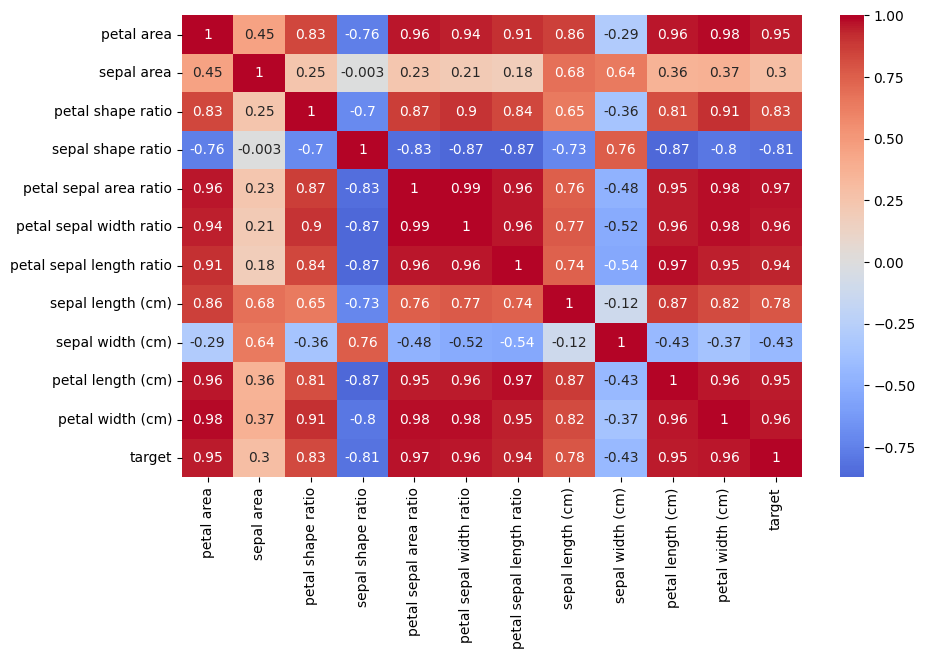

In [29]:
plt.figure(figsize=(10,6))
sns.heatmap(fe_dataset.corr(), annot=True, center=0.0, cmap='coolwarm')

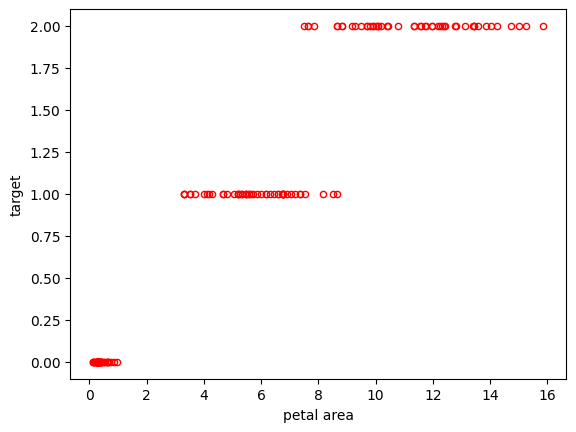

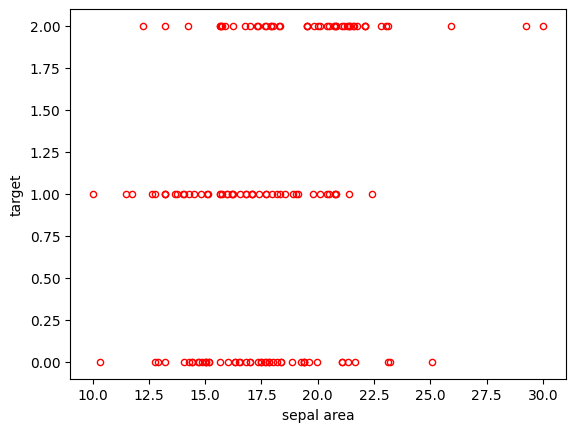

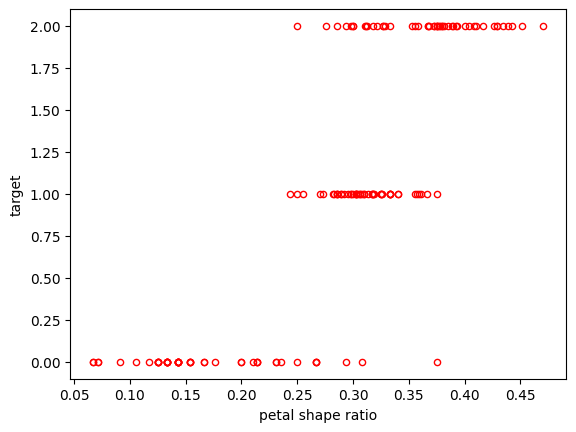

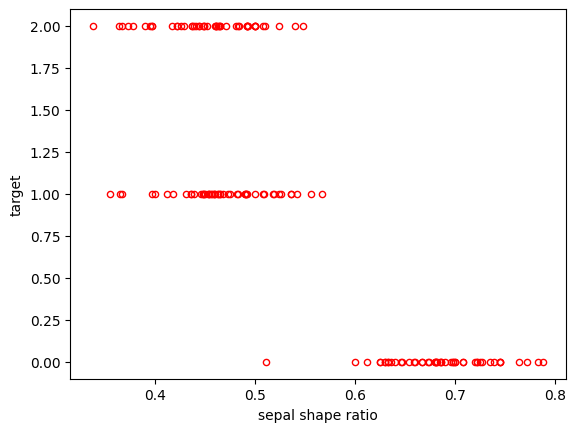

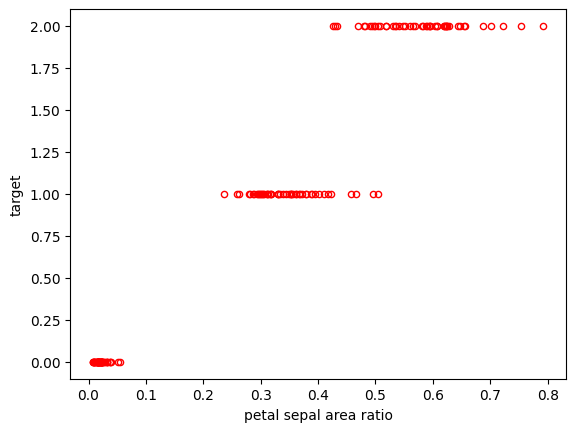

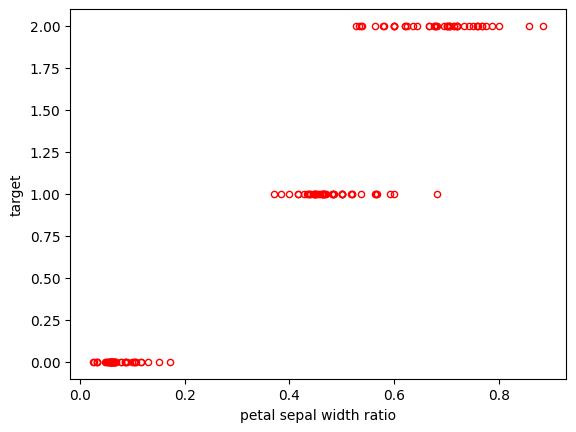

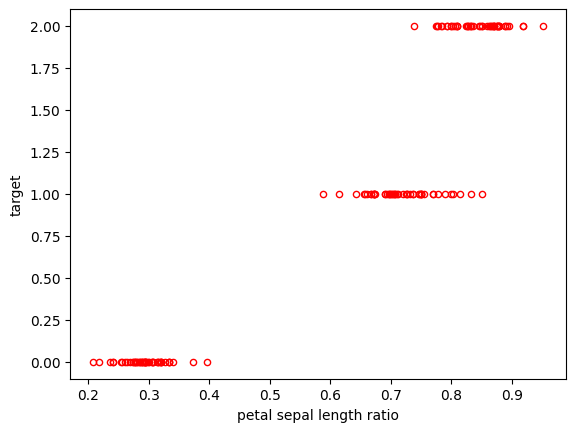

In [30]:
for feature in feature_crosses.columns:
  fe_dataset.plot(kind='scatter', x=feature, y=LABEL, facecolors='none', edgecolors='r', color="none")

# Cross Validation Evaluation

Because the number of examples is small, we will use cross validation to gain a better understanding of performance over unseen data. An 80:20 split ~ 30-40 test cases

In [31]:

def cv_evaluation(k, build_model, dataset):
  fold_accuracies = [] # Test accuracy on the individual folds.

  for  fold_idx, (train_indices, test_indices) in enumerate(KFold(n_splits=k, shuffle=True).split(dataset)):

    # Convert the examples into tensorflow datasets.
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(dataset.iloc[train_indices], label=LABEL)
    test_ds =  tfdf.keras.pd_dataframe_to_tf_dataset(dataset.iloc[test_indices], label=LABEL)

    # Train the model.
    model = build_model(random_seed = SEED)
    model.fit(train_ds, verbose=0)

    # Evaluate the model.
    model.compile(metrics=["accuracy"])
    test_acc = model.evaluate(test_ds, return_dict=True, verbose=0)['accuracy']
    fold_accuracies.append(test_acc)

  return np.mean(fold_accuracies)

# Part 1: Investigate performance incerease with DT, RF and GBT models

## Model 1: Classification Tree


In [32]:
cv_eval = cv_evaluation(5, tfdf.keras.CartModel, dataset)
fe_cv_eval = cv_evaluation(5, tfdf.keras.CartModel, fe_dataset)

print("\nWthout feature crosses: ", cv_eval)
print("With feature crosses:   ",   fe_cv_eval)

Use /tmp/tmp3ienw715 as temporary training directory


Use /tmp/tmpiuzi41z7 as temporary training directory


Use /tmp/tmp412748e8 as temporary training directory


Use /tmp/tmpgod_h8r_ as temporary training directory


Use /tmp/tmp30oiihkk as temporary training directory


Use /tmp/tmp_amfe1zs as temporary training directory


Use /tmp/tmpjdhoa8p2 as temporary training directory


Use /tmp/tmps8fmsgcg as temporary training directory


Use /tmp/tmpq4_4fcla as temporary training directory


Use /tmp/tmppvt47_2d as temporary training directory

Wthout feature crosses:  0.9333333134651184
With feature crosses:    0.9466666460037232


## Model 2: Random Forests


In [33]:
cv_eval = cv_evaluation(5, tfdf.keras.RandomForestModel, dataset)
fe_cv_eval = cv_evaluation(5, tfdf.keras.RandomForestModel, fe_dataset)

print("\nWthout feature crosses: ", cv_eval)
print("With feature crosses:   ",   fe_cv_eval)

Use /tmp/tmpabyfgtyv as temporary training directory


Use /tmp/tmp4coburxh as temporary training directory


Use /tmp/tmp6lhan1yp as temporary training directory


Use /tmp/tmp10qdbca6 as temporary training directory


Use /tmp/tmplvhq6edm as temporary training directory


Use /tmp/tmpmvq6tss6 as temporary training directory


Use /tmp/tmpe2xykjeq as temporary training directory


Use /tmp/tmpzwtu39ji as temporary training directory


Use /tmp/tmpyn6mb2u_ as temporary training directory


Use /tmp/tmp69ek6aue as temporary training directory

Wthout feature crosses:  0.9399999856948853
With feature crosses:    0.9599999785423279


## Model 3: GBT


In [34]:
cv_eval = cv_evaluation(5, tfdf.keras.GradientBoostedTreesModel, dataset)
fe_cv_eval = cv_evaluation(5, tfdf.keras.GradientBoostedTreesModel, fe_dataset)

print("\nWthout feature crosses: ", cv_eval)
print("With feature crosses:   ",   fe_cv_eval)

Use /tmp/tmpq01nmq4z as temporary training directory


Use /tmp/tmpz1w7w39c as temporary training directory


Use /tmp/tmpc1g7cx26 as temporary training directory


Use /tmp/tmpzfu5w3nc as temporary training directory


Use /tmp/tmpjkkmyfkr as temporary training directory


Use /tmp/tmptf986dox as temporary training directory


Use /tmp/tmpskygfu26 as temporary training directory


Use /tmp/tmpb2x3xiix as temporary training directory


Use /tmp/tmpi7fotdsb as temporary training directory


Use /tmp/tmpx5pn3gxx as temporary training directory

Wthout feature crosses:  0.9599999904632568
With feature crosses:    0.9466666460037232
